In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [65]:
class Network(object):
    
    def __init__(self):
        self.W1 = None
        self.b1 = 0
        self.W2 = None
        self.b2 = 0
        
    def load_data(self):
        image_size = 28 # width and length
        image_pixels = image_size * image_size
        train_data = np.loadtxt("mnist_train.csv", delimiter=",")
        test_data = np.loadtxt("mnist_test.csv", delimiter=",") 
        
        fac = 0.99 / 255
        train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
        test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01
        train_labels = np.asfarray(train_data[:, :1])
        test_labels = np.asfarray(test_data[:, :1])

        val_indexes = []
        for index in range(10):
            indices = np.where(train_labels==index)[0]
            val_indexes.extend(np.random.choice(indices, int(0.2*len(indices)), replace=False))
        val_indexes = np.asarray(val_indexes)
        val_imgs = train_imgs[val_indexes]
        train_imgs = np.delete(train_imgs, val_indexes, axis=0)
        val_labels = train_labels[val_indexes]
        train_labels = np.delete(train_labels, val_indexes, axis=0)

        lr = np.arange(10.0)
        # transform labels into one hot representation
#         train_labels_one_hot = (lr==train_labels).astype(np.int)
#         test_labels_one_hot = (lr==test_labels).astype(np.int)
#         val_labels_one_hot = (lr==val_labels).astype(np.int)
        train_labels_one_hot = np.eye(10)[train_labels.reshape(-1).astype(int)]
        val_labels_one_hot = np.eye(10)[val_labels.reshape(-1).astype(int)]
        test_labels_one_hot = np.eye(10)[test_labels.reshape(-1).astype(int)]

        # we don't want zeroes and ones in the labels neither:
        train_labels_one_hot[train_labels_one_hot==0] = 0.01
        train_labels_one_hot[train_labels_one_hot==1] = 0.99
        test_labels_one_hot[test_labels_one_hot==0] = 0.01
        test_labels_one_hot[test_labels_one_hot==1] = 0.99
        val_labels_one_hot[val_labels_one_hot==0] = 0.01
        val_labels_one_hot[val_labels_one_hot==1] = 0.99   
        
        return (train_imgs, test_imgs, val_imgs, train_labels, val_labels, test_labels,
               train_labels_one_hot, val_labels_one_hot, test_labels_one_hot)
    
    def create_mini_batch(self, indexes):
        np.random.shuffle(indexes)
        return np.split(indexes, 100)
        
    def hypothesis(self, X, w=None, b=None):
        f = np.dot(X,w) + b
        f = np.exp(f)
        denom = f.sum(axis=1)
        for i in range(len(denom)):
            f[i,:] /= denom[i]
        return f
    
    def forward(self, X):
        hidden = self.hypothesis(X, self.W1, self.b1)
        output = self.hypothesis(hidden, self.W2, self.b2)
        return hidden, output
    
    def loss(self, p, y, w=None, lamb=0.9):        
        return -1 * (np.sum(y*np.log(p))/len(y) + (lamb/2) * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2))))
    
    def gradients(self, X, Y, step_size=0.8):
        hidden, p = self.forward(X)
        
        dj_dw2 = np.dot(hidden.T, (p - Y))
        dj_db2 = sum(p - Y)
        
        dj_db1 = np.multiply(np.dot(self.W2,sum(p-Y)), 1-hidden*hidden)
        dj_dw1 = np.dot(X.T, dj_db1)
        
        result = np.array([[dj_dw2, dj_db2],
                           [dj_dw1, sum(dj_db1)]])
        return result

    
    def train(self, X, Y, step_size=0.01):
        delta_a = self.gradients(X, Y)
        self.W2 -= step_size * delta_a[0][0]
        self.b2 -= step_size * delta_a[0][1]
        self.W1 -= step_size * delta_a[1][0]
        self.b1 -= step_size * delta_a[1][1]
        z, p = self.forward(X)
        correct, total = 0, 0
        for index in range(len(p)):
            if np.argmax(p[index]) == np.argmax(Y[index]):
                correct += 1
            total += 1
        J = self.loss(p, Y)
#         loss_per_epoch.append(J)
        return J, round(correct/total)

    def confusion_matrix(self, cm, data, labels):
        z, p = self.forward(data)
        for index in range(len(data)):
            if np.argmax(p[index]) == np.argmax(labels[index]):
                cm[np.argmax(p[index]), np.argmax(labels[index])] += 1
        return cm
    
    def main(self):
        (train_imgs, test_imgs, val_imgs, train_labels, val_labels, test_labels, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot) = self.load_data()
        D = 784
        k = len(np.unique(train_labels))
        num_h_units = 20
        np.random.seed(1)
        self.W1 = np.random.normal(0, 1, (D, num_h_units)) 
        self.W2 = np.random.normal(0, 1, (num_h_units, k)) 

        self.b1 = np.random.random(num_h_units) 
        self.b2 = np.random.random(k) 
        
        epochs = 100
        train_loss = []
        train_accuracy = []
        old_val_loss = 0
        cur_val_loss = np.Inf
        val_loss = []
        val_accuracy = []
        test_loss = []
        test_accuracy = []
        count = 0
        train_imgs = train_imgs[:-4]
        train_labels = train_labels[:-4]
        train_labels_one_hot = train_labels_one_hot[:-4]
        for count in range(epochs):
            average_loss = 0
            average_accuracy = 0
            batches = self.create_mini_batch(np.arange(len(train_imgs)))
            for batch in batches:
#                 train_x, train_y = batch[:,:-1], self.one_hot(batch[:,-1])
                train_x, train_y = train_imgs[batch], train_labels_one_hot[batch]
                batch_loss, batch_accuracy = self.train(train_x, train_y)
                average_loss += batch_loss
                average_accuracy += batch_accuracy
            train_loss.append(round(average_loss/len(batches), 2))
            train_accuracy.append(round(average_accuracy/len(batches), 2))
            z, p = self.forward(val_imgs)
            old_val_loss = cur_val_loss
            cur_val_loss = self.loss(p, val_labels_one_hot)
            val_loss.append(round(cur_val_loss, 2))
            correct = 0
            total = 0
            for index in range(len(p)):
                if np.argmax(p[index]) == val_labels[index]:
                    correct += 1
                total += 1
            val_accuracy.append(round(correct/total, 2))
            if cur_val_loss > old_val_loss:
                break
        
        z, p = self.forward(test_imgs)
        test_loss = self.loss(p, test_labels_one_hot)
        class_acc = np.zeros(10)
        class_total = np.zeros(10)
        for index in range(len(test_labels_one_hot)):
            if np.argmax(test_labels_one_hot[index]) == np.argmax(p[index]):
                class_acc[np.argmax(test_labels_one_hot[index])] += 1
            class_total[np.argmax(test_labels_one_hot[index])] += 1
        for index in range(10):
            class_acc[index] /= class_total[index]
        
        %matplotlib notebook
        plt.plot(train_loss, label='Training loss')
        plt.plot(val_loss, label='Validation loss')
        plt.axvline(x=count, color='g', label='Early stopping')
        plt.legend(loc='upper right')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss value')
        plt.title('Graph of Loss values')
        plt.show()
        
        %matplotlib notebook
        plt.hist(class_acc, normed=True, bins=30)
        plt.title('Class wise accuracy values')
        plt.xlabel('Class numbers')
        plt.ylabel('Accuracy values')
        plt.show()
        
        cm = np.zeros((10,10), int)
        cm = self.confusion_matrix(cm, train_imgs, train_labels_one_hot)
        cm = self.confusion_matrix(cm, val_imgs, val_labels_one_hot)
        cm = self.confusion_matrix(cm, test_imgs, test_labels_one_hot)
        print('Confusion matrix:')
        print(cm)
        

/Users/hitesh/Documents/machine learning/pytorchProjects/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
/Users/hitesh/Documents/machine learning/pytorchProjects/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


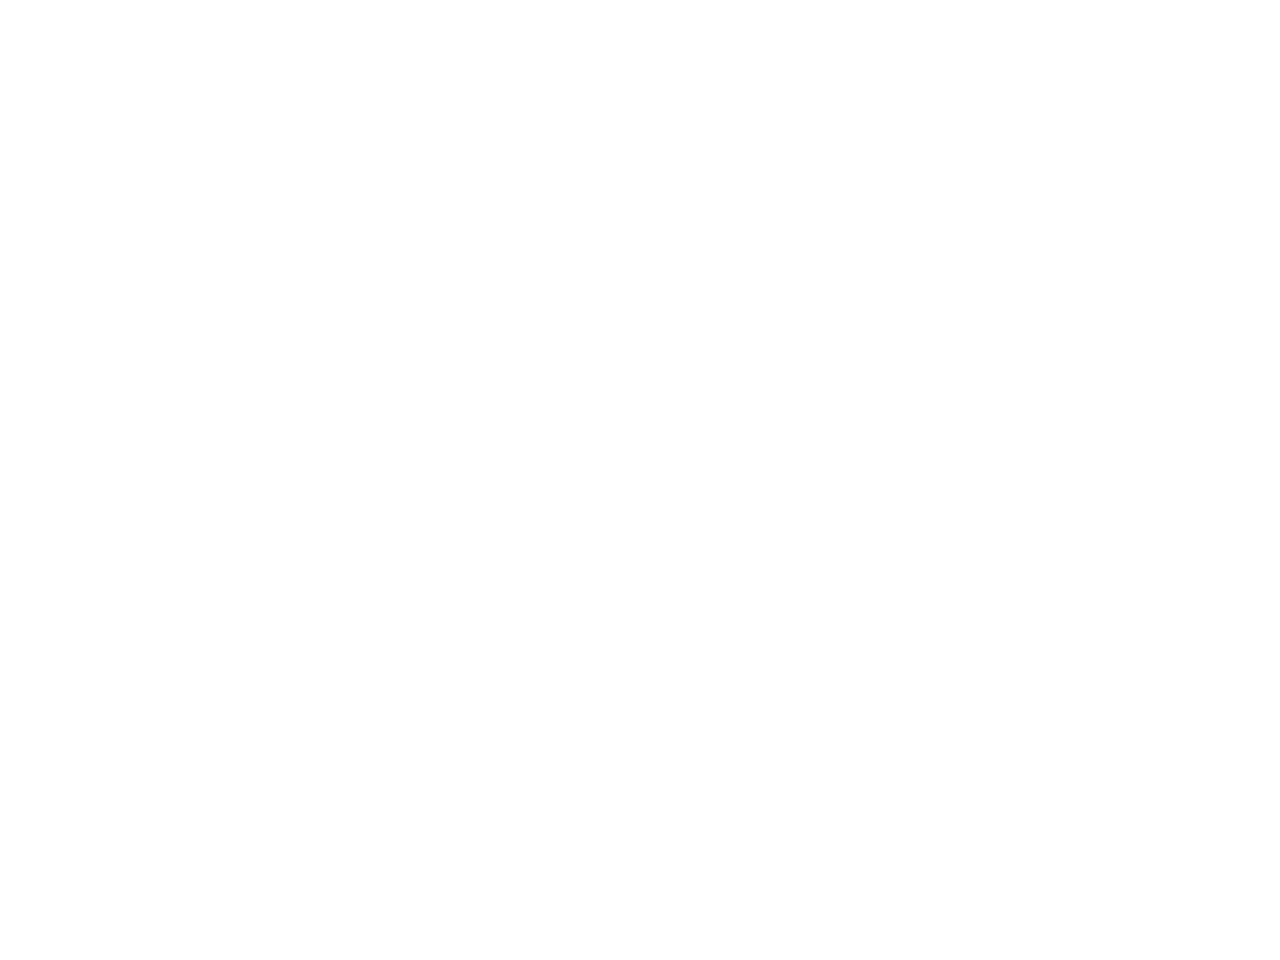

<IPython.core.display.Javascript object>


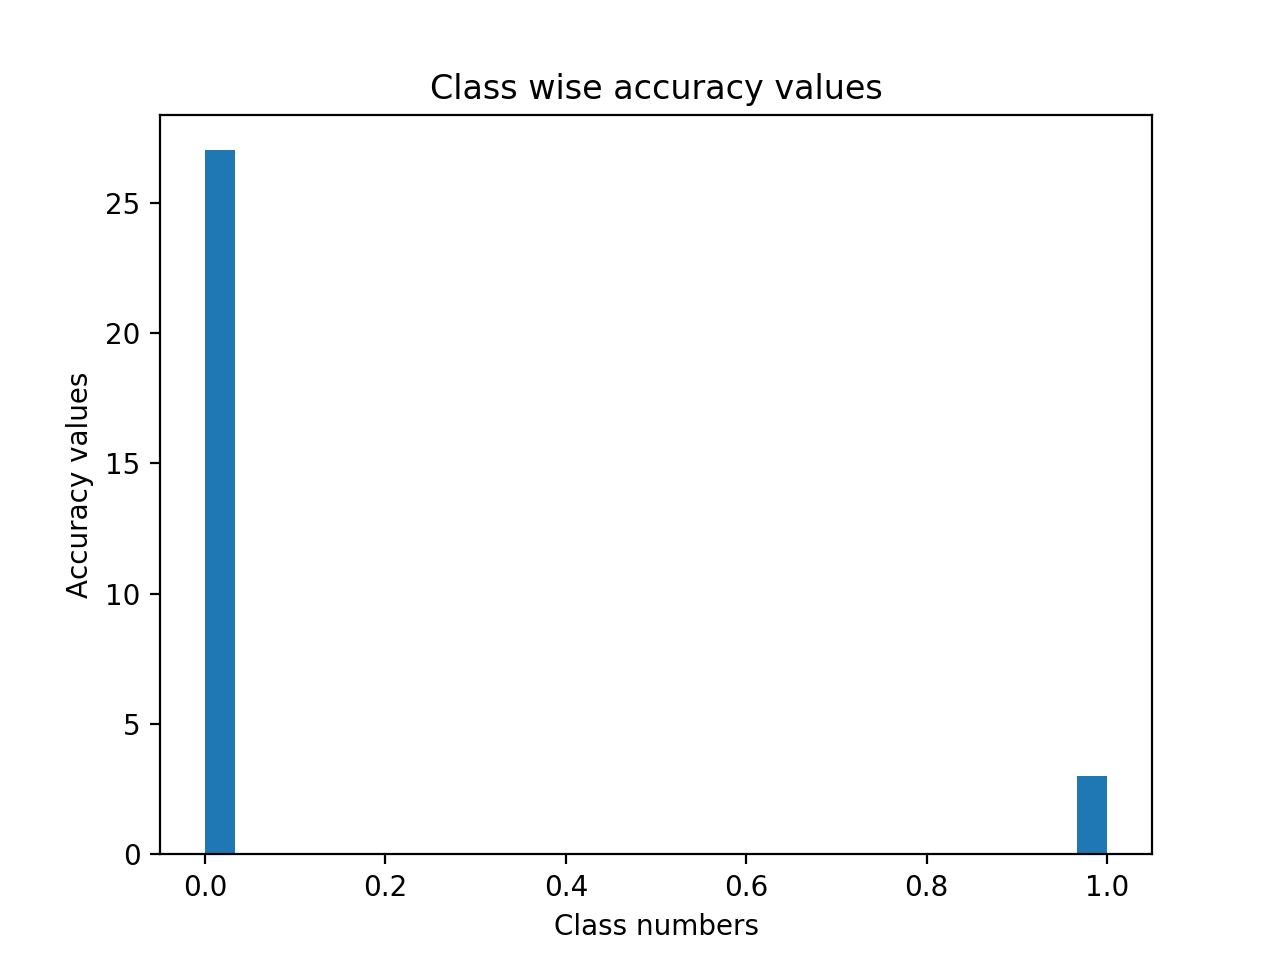

/Users/hitesh/Documents/machine learning/pytorchProjects/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Confusion matrix:
[[6903    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


In [66]:
net = Network()
net.main()